In [1]:
# Import modules and dependencies
import acc_library as al
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import fast_track
import os
from scipy.optimize import curve_fit
import pickle
import scipy.stats as st
#%matplotlib inline
%matplotlib notebook

ImportError: No module named acc_library

In [2]:
# Functions: modified to read maximum number of coefficients

def getPTCmap(file_name):
    _, data_ptc = al.readtfs(file_name)
    data_ptc['INDEX'] = np.ones(len(data_ptc.index))
    groupped = data_ptc.groupby(['N_VECTOR']).sum()
    
    # Generalised for 6D
    #C = np.zeros((6, int(groupped['INDEX'].iloc[0])))
    #exps = np.zeros((6, int(groupped['INDEX'].iloc[0]), 6))
    
    C = np.zeros((6, int(groupped['INDEX'].max())))    
    exps = np.zeros((6, int(groupped['INDEX'].max()), 6))
 
    for i in xrange(C.shape[0]-1):
        new_data = data_ptc[data_ptc['N_VECTOR'] == i + 1]
        vec_tmp = new_data['COEF']
        C[i, 0:len(vec_tmp)] = vec_tmp
 
        exp_tmp = [np.array(map(int, list(str(new_data.index[j][3:])))) for j in xrange(len(vec_tmp))]
        exps[i, 0:len(vec_tmp), :] = exp_tmp
        if np.all(exps[i, 0] == [0.] * 6):
            print('+++Warning: CO removed!')
            C[i, 0] = 0.0    
            
    return C, exps


def quickZScheck(zs, particles):

    out = []

    n_p = particles.shape[1]

    for i in xrange(n_p):
        if particles[0, i] > zs:
            out.append(i)

    return np.delete(particles, np.s_[out], 1), out

def trackPTC(particles_input, turns, zs, co, C_maps, exps_maps, turnByTurn=False):

    #zs = zs_x - co_zs
 
    particles_int = np.copy(particles_input - co)
    
    print 'Closed-orbit removed for tracking, X0 = ' + str(np.mean(particles_int[0,:]))
    
    n_part = particles_int.shape[1]

    out_log = np.zeros((0,6))

    tmp_dpp = particles_int[5, :].copy()
    particles_int[5, :] = particles_int[4, :].copy()
    particles_int[4, :] = tmp_dpp
    
    
    if turnByTurn:
        particles_tot = np.zeros((particles_int.shape[0], particles_int.shape[1], turns))

    
    for turn in xrange(turns):      
        if turnByTurn:
            particles_tot[:, :particles_int.shape[1], turn] = particles_int
              
        for i in range(len(C_maps)):
            particles_int = fast_track.trackNonLinearSinglePTC(C_maps[i], exps_maps[i], particles_int)
                   
        #particles_int0, out = quickZScheck(zs, particles_int)
        
        #for j in out:
        #    out_log = np.vstack((out_log, particles_int[:,j].T))
            
        #particles_int = particles_int0
    
    if turnByTurn:
        tmp_dpp = particles_tot[5, :, :].copy()
        particles_tot[5, :, :] = particles_tot[4, :, :].copy()
        particles_tot[4, :, :] = tmp_dpp
        for turn in xrange(turns):
            particles_tot[:,:,turn] =  particles_tot[:,:,turn] + co
        return particles_tot, out_log

    else:
        tmp_dpp = particles_int[5, :].copy()
        particles_int[5, :] = particles_int[4, :].copy()
        particles_int[4, :] = tmp_dpp
        return particles_int + co
    
def trackPTCtest(particles_input, turns, zs, co, C_maps, exps_maps, turnByTurn=False, lastNturns = False, lastN = 100):
    
    #zs = zs_x - co_zs
 
    particles_int = np.copy(particles_input - co)
    
    print 'Closed-orbit removed for tracking, X0 = ' + str(np.mean(particles_int[0,:]))
    
    n_part = particles_int.shape[1]

    out_log = np.zeros((0,6))

    tmp_dpp = particles_int[5, :].copy()
    particles_int[5, :] = particles_int[4, :].copy()
    particles_int[4, :] = tmp_dpp
    
    
    if turnByTurn:
        if lastNturns:
            particles_tot = np.zeros((particles_int.shape[0], particles_int.shape[1], lastN))
        else:
            particles_tot = np.zeros((particles_int.shape[0], particles_int.shape[1], turns))
    
    for turn in xrange(turns):      
        if turnByTurn:
            if lastNturns:
                if turns - turn <= lastN:
                    particles_tot[:, :particles_int.shape[1], turn - turns + lastN] = particles_int 
            else:
                particles_tot[:, :particles_int.shape[1], turn] = particles_int
              
        for i in range(len(C_maps)):
            particles_int = fast_track.trackNonLinearSinglePTC(C_maps[i], exps_maps[i], particles_int)
                   
        #particles_int0, out = quickZScheck(zs, particles_int)
        
        #for j in out:
        #    out_log = np.vstack((out_log, particles_int[:,j].T))
            
        #particles_int = particles_int0
    
    if turnByTurn:
        tmp_dpp = particles_tot[5, :, :].copy()
        particles_tot[5, :, :] = particles_tot[4, :, :].copy()
        particles_tot[4, :, :] = tmp_dpp
        if lastNturns:
            for turn in xrange(lastN):
                particles_tot[:,:,turn] =  particles_tot[:,:,turn] + co 
        else:
            for turn in xrange(turns):
                particles_tot[:,:,turn] =  particles_tot[:,:,turn] + co
        return particles_tot, out_log

    else:
        tmp_dpp = particles_int[5, :].copy()
        particles_int[5, :] = particles_int[4, :].copy()
        particles_int[4, :] = tmp_dpp
        return particles_int + co
    
def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)

In [3]:
# Load PTC Twiss data and CO

#header_ptc, data_ptc_ref = al.readtfs('./frozen/QX218_QY240/order5/ptc_twiss_ref.tfs')
header_ptc, data_ptc_ref = al.readtfs('./frozen/QX218_QY235/order5/ptc_twiss_ref.tfs')
#header_ptc, data_ptc_ref = al.readtfs('./ptc_twiss_ref.tfs')
co = np.array([[header_ptc['ORBIT_X'],header_ptc['ORBIT_PX'],header_ptc['ORBIT_Y'],header_ptc['ORBIT_PY'],0,header_ptc['ORBIT_PT']]]).T

# Load PTC map coefficients
#C_OTM, exps_OTM = getPTCmap('./frozen/QX218_QY240/order5/ptc_map_start_map_stop_map.tfs')
C_OTM, exps_OTM = getPTCmap('./frozen/QX218_QY235/order5/ptc_map_start_map_stop_map.tfs')

# Check Map tune
print 'Q1 = ' + str(header_ptc['Q1'])

# Define relativistic beta for PT
header_ptc['BETA'] = np.sqrt(1-1/header_ptc['GAMMA']**2)

print "Relativistic beta = " + str(header_ptc['BETA'])

+++Warning: CO removed!
+++Warning: CO removed!
Q1 = 0.2179966476
Relativistic beta = 0.9158392701347501


In [4]:
# Compared dipsersion with measured TbT data

# Load TbT measurement data

# Open pickled data
data = dict(OP_H = {}, ReM_H = {})

f = open("/Users/mfraser/cernbox/PS/T-B-T/OP_H_SEM_29t", "r")

# Main dataset
dataOP = pickle.load(f)

data['OP_H']['turnN'] = pickle.load(f)
data['OP_H']['turnN_fine'] = pickle.load(f)
data['OP_H']['BPM_D'] = pickle.load(f)
data['OP_H']['BPM_D_err'] = pickle.load(f)
data['OP_H']['BPM_D2'] = pickle.load(f)
data['OP_H']['BPM_D2_err'] = pickle.load(f)
data['OP_H']['BPM_q'] = pickle.load(f)
data['OP_H']['BPM_q_err'] = pickle.load(f)
data['OP_H']['D_mismatch'] = pickle.load(f)
data['OP_H']['D_mismatch_err'] = pickle.load(f)
data['OP_H']['D_mismatch_norm'] = pickle.load(f)
data['OP_H']['D_mismatch_norm_err'] = pickle.load(f)
data['OP_H']['SEM_D'] = pickle.load(f)
data['OP_H']['SEM_D_err'] = pickle.load(f)
data['OP_H']['SEM_D2'] = pickle.load(f)
data['OP_H']['SEM_D2_err'] = pickle.load(f)
data['OP_H']['D_mismatch_SEM'] = pickle.load(f)
data['OP_H']['D_mismatch_SEM_err'] = pickle.load(f)
data['OP_H']['D_mismatch_SEM_norm'] = pickle.load(f)
data['OP_H']['D_mismatch_SEM_norm_err'] = pickle.load(f)

f.close()

f = open("/Users/mfraser/cernbox/PS/T-B-T/ReM_H_SEM_29t", "r")

# Main dataset
dataReM_H = pickle.load(f)

data['ReM_H']['turnN'] = pickle.load(f)
data['ReM_H']['turnN_fine'] = pickle.load(f)
data['ReM_H']['BPM_D'] = pickle.load(f)
data['ReM_H']['BPM_D_err'] = pickle.load(f)
data['ReM_H']['BPM_D2'] = pickle.load(f)
data['ReM_H']['BPM_D2_err'] = pickle.load(f)
data['ReM_H']['BPM_q'] = pickle.load(f)
data['ReM_H']['BPM_q_err'] = pickle.load(f)
data['ReM_H']['D_mismatch'] = pickle.load(f)
data['ReM_H']['D_mismatch_err'] = pickle.load(f)
data['ReM_H']['D_mismatch_norm'] = pickle.load(f)
data['ReM_H']['D_mismatch_norm_err'] = pickle.load(f)
data['ReM_H']['SEM_D'] = pickle.load(f)
data['ReM_H']['SEM_D_err'] = pickle.load(f)
data['ReM_H']['SEM_D2'] = pickle.load(f)
data['ReM_H']['SEM_D2_err'] = pickle.load(f)
data['ReM_H']['D_mismatch_SEM'] = pickle.load(f)
data['ReM_H']['D_mismatch_SEM_err'] = pickle.load(f)
data['ReM_H']['D_mismatch_SEM_norm'] = pickle.load(f)
data['ReM_H']['D_mismatch_SEM_norm_err'] = pickle.load(f)

f.close()   

2.5524909916380167 2.352332966


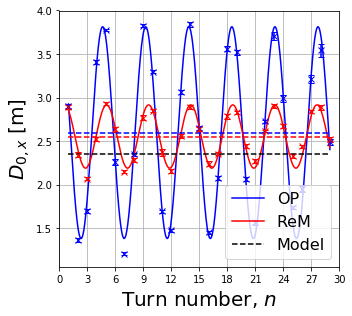

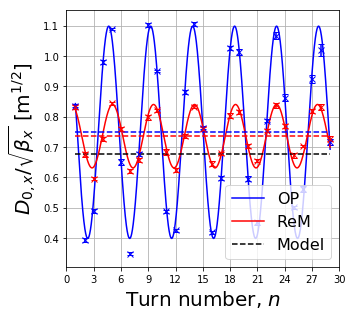

In [5]:
# Plot the TbT H dispersion measured on the SEM grid with errors:

N_turns= 29

turnN = data['OP_H']['turnN']
turnN_fine = data['OP_H']['turnN_fine']
SEM_D_OP_H = data['OP_H']['SEM_D']
SEM_D_err_OP_H = data['OP_H']['SEM_D_err']
SEM_D2_OP_H = np.array(data['OP_H']['SEM_D2'])*1000
SEM_D2_err_OP_H = np.array(data['OP_H']['SEM_D2_err'])*1000

SEM_D_ReM_H = data['ReM_H']['SEM_D']
SEM_D_err_ReM_H = data['ReM_H']['SEM_D_err']
SEM_D2_ReM_H = np.array(data['ReM_H']['SEM_D2'])*1000
SEM_D2_err_ReM_H = np.array(data['ReM_H']['SEM_D2_err'])*1000

# Plot the turn-by-turn  dispersion measured on the SEM grid with errors:

plt.figure('DX',figsize=(5,4.5))

popt_OP_H, pcov_OP_H = curve_fit(Md_fit,turnN,SEM_D_OP_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.errorbar(turnN,SEM_D_OP_H,yerr=SEM_D_err_OP_H, linestyle = 'None', marker = 'x',color = 'b', capsize = 3)
plt.plot(turnN_fine,Md_fit(turnN_fine,popt_OP_H[0],popt_OP_H[1],popt_OP_H[2],popt_OP_H[3]),'b',label = 'OP')

popt_ReM_H, pcov_ReM_H = curve_fit(Md_fit,turnN,SEM_D_ReM_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.errorbar(turnN,SEM_D_ReM_H,yerr=SEM_D_err_ReM_H, linestyle = 'None', marker = 'x',color = 'r', capsize = 3)
plt.plot(turnN_fine,Md_fit(turnN_fine,popt_ReM_H[0],popt_ReM_H[1],popt_ReM_H[2],popt_ReM_H[3]),'r',label = 'ReM')

plt.plot([turnN[0], turnN[-1]], [data_ptc_ref['DISP1']['PI.BSG52'],data_ptc_ref['DISP1']['PI.BSG52']],'--k',label = 'Model')

plt.plot([turnN[0], turnN[-1]], [popt_ReM_H[0],popt_ReM_H[0]],'--r')

plt.plot([turnN[0], turnN[-1]], [popt_OP_H[0],popt_OP_H[0]],'--b')


plt.xlabel('Turn number, $n$')
plt.ylabel(r'$D_{0,x}$ [m]')
#plt.title('PI.BSG52')
plt.xlim((0,30))
plt.grid()
plt.legend(loc = 'lower right')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/TbT/BSGH_Dmeas_OPvsReM.png', dpi = 600)

# Plot the turn-by-turn Normalised dispersion measured on the SEM grid with errors:

plt.figure('DX/sqrt(BETX)',figsize=(5,4.5))

popt_OP_H, pcov_OP_H = curve_fit(Md_fit,turnN,SEM_D_OP_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.errorbar(turnN,SEM_D_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D_err_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3)
plt.plot(turnN_fine,Md_fit(turnN_fine,popt_OP_H[0],popt_OP_H[1],popt_OP_H[2],popt_OP_H[3])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'b',label = 'OP')

popt_ReM_H, pcov_ReM_H = curve_fit(Md_fit,turnN,SEM_D_ReM_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.errorbar(turnN,SEM_D_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D_err_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'r', capsize = 3)
plt.plot(turnN_fine,Md_fit(turnN_fine,popt_ReM_H[0],popt_ReM_H[1],popt_ReM_H[2],popt_ReM_H[3])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'r',label = 'ReM')

plt.plot([turnN[0], turnN[-1]], [data_ptc_ref['DISP1']['PI.BSG52']/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),data_ptc_ref['DISP1']['PI.BSG52']/np.sqrt(data_ptc_ref['BETX']['PI.BSG52'])],'--k',label = 'Model')

plt.plot([turnN[0], turnN[-1]], [popt_ReM_H[0]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),popt_ReM_H[0]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52'])],'--r')

plt.plot([turnN[0], turnN[-1]], [popt_OP_H[0]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),popt_OP_H[0]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52'])],'--b')

plt.xlabel('Turn number, $n$')
plt.ylabel(r'$D_{0,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
#plt.title('PI.BSG52')
plt.xlim((0,30))
plt.grid()
plt.legend(loc = 'lower right')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/TbT/BSGH_D_norm_meas_OPvsReM.png', dpi = 600)

print popt_ReM_H[0], data_ptc_ref['DISP1']['PI.BSG52']

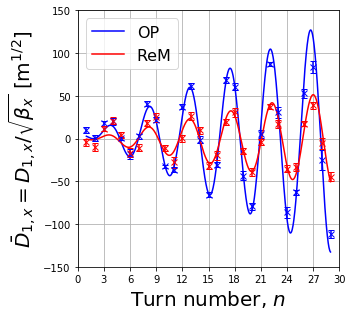

In [6]:
# Plot the measured turn-by-turn non-linear dispersion

def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

plt.figure(figsize=(5,4.5))

plt.errorbar(turnN,SEM_D2_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D2_err_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3) 
popt, pcov = curve_fit(Md_ramp_fit,turnN,SEM_D2_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,150./31,1.35,-np.inf),(10,150./10,1.42,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt[0],popt[1],popt[2],popt[3]),'-b',label = 'OP')

plt.errorbar(turnN,SEM_D2_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D2_err_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'r', capsize = 3) 
popt, pcov = curve_fit(Md_ramp_fit,turnN,SEM_D2_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,50./25,1.31,-np.inf),(10,50./10,1.33,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt[0],popt[1],popt[2],popt[3]),'-r',label = 'ReM')

plt.grid()
plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\bar{D}_{1,x} = D_{1,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.xlim((0,N_turns+1))
plt.ylim((-150,150))
plt.legend(loc = 'lower left')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/TbT/BSGH_D2meas_OPvsReM.png')


2.6327274483633305 -0.11044344187800001
Closed-orbit removed for tracking, X0 = 4.865687798471532e-18


//anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


" \nfor i in range(0,N_turns-1):\n    fig = plt.figure('BSGH52 on turn ' + str(i+1), figsize = (3,3) )\n    plt.title('BSGH52 on turn ' + str(i+1) )\n    plt.plot(particles_tot[5,:,i]*1e3,particles_tot[0,:,i]*1e3,'bx')\n    popt, pcov = curve_fit(cubic,particles_tot[5,:,i],particles_tot[0,:,i])\n    DELTAP_range = np.arange(np.min(particles_tot[5,:,i]),np.max(particles_tot[5,:,i]),0.1e-4)        \n    plt.plot(DELTAP_range*1e3,cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3])*1e3,'-r')\n    SEM_D_OP.append(popt[1])\n    SEM_D2_OP.append(popt[0]) \n    plt.xlabel(r'$\\Delta p/p$ [$10^{-3}$]')\n    plt.ylabel(r'$x$ [mm]')\n    plt.ylim(-10,10)\n    plt.tight_layout()\n    plt.grid()\n    \n    plt.savefig('./gif/OP/NL_DX/BSGH/PT_X_turn' + str(i+1) + '.png')\n"

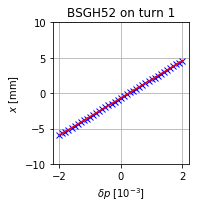

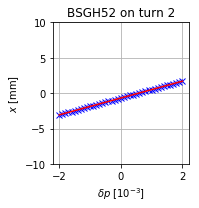

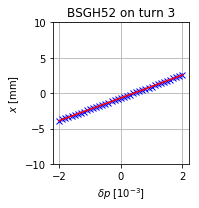

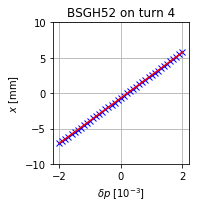

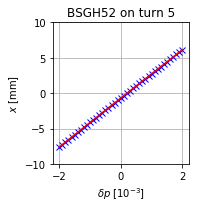

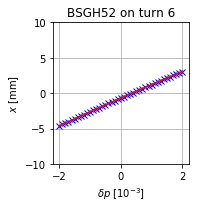

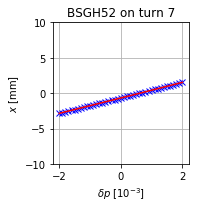

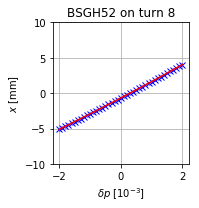

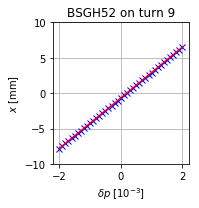

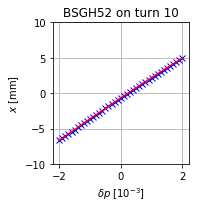

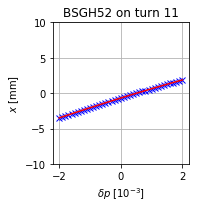

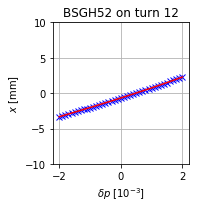

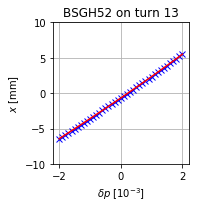

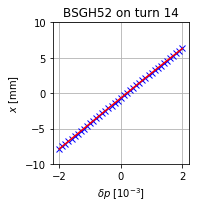

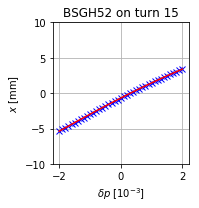

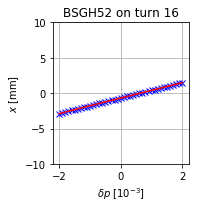

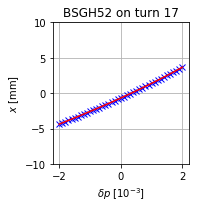

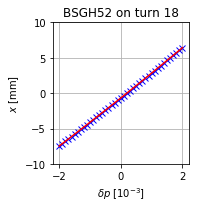

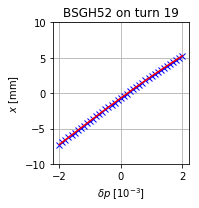

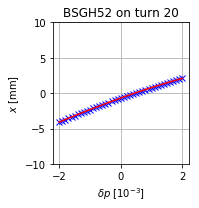

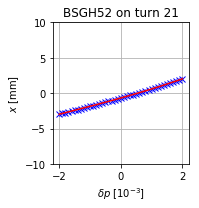

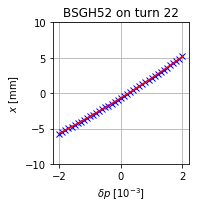

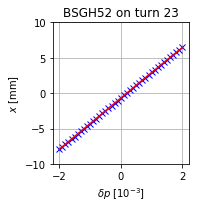

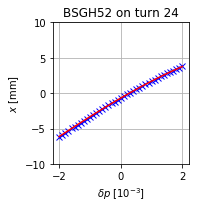

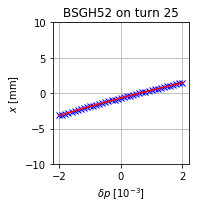

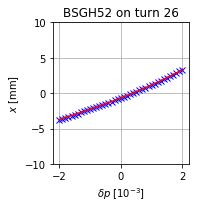

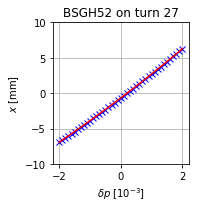

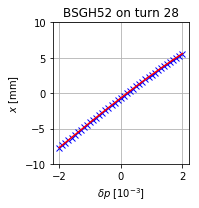

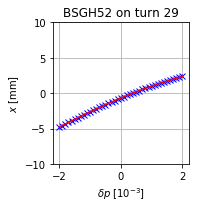

In [7]:
# Plot the simulated TbT H dispersion with measured fit constants:

# OP optics

def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)
    
# Define initial particle coordinates for tracking

DX0 = Md_fit(1, popt_OP_H[0], popt_OP_H[1], popt_OP_H[2], popt_OP_H[3])*0.9
DPX0 = data_ptc_ref['DISP2']['PI.BSG52']*14
DELTAP = np.arange(-2.,2.1,0.1)*1e-3

print DX0, DPX0

X0 = DELTAP*DX0 + co[0]
PX0 = DELTAP*DPX0 + co[1]

def cubic(x,a,m,c,b):
    return a*x**2 + x*m + c + b*x**3

particle0 = []
for idx, i in enumerate(DELTAP*header_ptc['BETA']):
    particle0.append([X0[idx], PX0[idx],0,0,0,i])
    #print i, X0[idx]

particles_tot, out_log = trackPTC(np.array(particle0).T, 30, 68, co, [C_OTM], [exps_OTM], turnByTurn=True)

N_turns = 30
#fig = plt.figure('BSGH52 at Turn' + str(i+1))
SEM_D_OP = []  
SEM_D2_OP = []  


for i in range(0,N_turns-1):
    fig = plt.figure('BSGH52 on turn ' + str(i+1), figsize = (3,3) )
    plt.title('BSGH52 on turn ' + str(i+1) )
    plt.plot(particles_tot[5,:,i]*1e3/header_ptc['BETA'],particles_tot[0,:,i]*1e3,'bx')
    popt, pcov = curve_fit(cubic,particles_tot[5,:,i]/header_ptc['BETA'],particles_tot[0,:,i])
    DELTAP_range = np.arange(np.min(particles_tot[5,:,i]/header_ptc['BETA']),np.max(particles_tot[5,:,i]/header_ptc['BETA']),0.1e-4)        
    plt.plot(DELTAP_range*1e3,cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3])*1e3,'-r')
    SEM_D_OP.append(popt[1])
    SEM_D2_OP.append(popt[0]) 
    plt.xlabel(r'$\delta p$ [$10^{-3}$]')
    plt.ylabel(r'$x$ [mm]')
    plt.xlim(DELTAP_range[0]*1.1e3,DELTAP_range[-1]*1.1e3)
    plt.ylim(-10,10)
    plt.tight_layout()
    plt.grid()
    #fig.clear()
    #plt.close(fig)
    
    plt.savefig('./gif/OP/NL_DX/BSGH/PT_X_turn' + str(i+1) + '.png')
 
""" 
for i in range(0,N_turns-1):
    fig = plt.figure('BSGH52 on turn ' + str(i+1), figsize = (3,3) )
    plt.title('BSGH52 on turn ' + str(i+1) )
    plt.plot(particles_tot[5,:,i]*1e3,particles_tot[0,:,i]*1e3,'bx')
    popt, pcov = curve_fit(cubic,particles_tot[5,:,i],particles_tot[0,:,i])
    DELTAP_range = np.arange(np.min(particles_tot[5,:,i]),np.max(particles_tot[5,:,i]),0.1e-4)        
    plt.plot(DELTAP_range*1e3,cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3])*1e3,'-r')
    SEM_D_OP.append(popt[1])
    SEM_D2_OP.append(popt[0]) 
    plt.xlabel(r'$\Delta p/p$ [$10^{-3}$]')
    plt.ylabel(r'$x$ [mm]')
    plt.ylim(-10,10)
    plt.tight_layout()
    plt.grid()
    
    plt.savefig('./gif/OP/NL_DX/BSGH/PT_X_turn' + str(i+1) + '.png')
"""    

0.34990814807239373


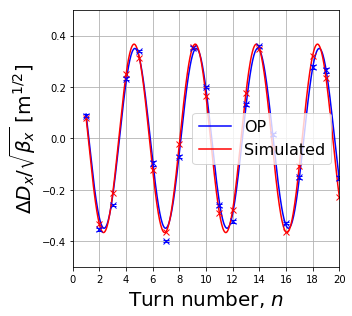

In [8]:
# Plot together the measured and simulated turn-by-turn Normalised dispersion:

plt.figure(figsize=(5,4.5))

popt_OP_H, pcov_OP_H = curve_fit(Md_fit,turnN,SEM_D_OP_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.errorbar(turnN,(SEM_D_OP_H-popt_OP_H[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D_err_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3)
plt.plot(turnN_fine,(Md_fit(turnN_fine,popt_OP_H[0],popt_OP_H[1],popt_OP_H[2],popt_OP_H[3])-popt_OP_H[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'b',label = 'OP')

popt_OP_H_sim, pcov_OP_H_sim = curve_fit(Md_fit,turnN,SEM_D_OP,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.plot(range(1,N_turns),(SEM_D_OP-popt_OP_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'xr')
plt.plot(turnN_fine,(Md_fit(turnN_fine,popt_OP_H_sim[0],popt_OP_H_sim[1],popt_OP_H_sim[2],popt_OP_H_sim[3])-popt_OP_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'r',label = 'Simulated')


plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\Delta D_{x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
#plt.title('PI.BSG52')
plt.xlim((0,20))
plt.ylim((-0.5,0.5))
plt.grid()
plt.legend(loc = 'lower right')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/OP/BSGH_DX.png')

print popt_OP_H[1]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52'])

1.3586310965714985
1.3978744875863331


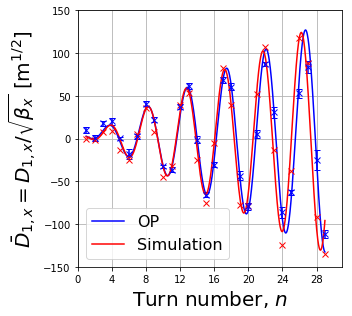

In [9]:
# Plot the turn-by-turn non-linear dispersion

def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

plt.figure(figsize=(5,4.5))

plt.errorbar(turnN,SEM_D2_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D2_err_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3) 
popt, pcov = curve_fit(Md_ramp_fit,turnN,SEM_D2_OP_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,150./31,1.35,-np.inf),(10,150./10,1.42,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt[0],popt[1],popt[2],popt[3]),'-b',label = 'OP')

plt.plot(turnN,SEM_D2_OP,'xr')
popt_OP_H_sim_D2, pcov_OP_H_sim_D2 = curve_fit(Md_ramp_fit,turnN,SEM_D2_OP/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,150./31,1.35,-np.inf),(10,150./10,1.42,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt_OP_H_sim_D2[0],popt_OP_H_sim_D2[1],popt_OP_H_sim_D2[2],popt_OP_H_sim_D2[3]),'-r',label = 'Simulation')

plt.grid()
plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\bar{D}_{1,x} = D_{1,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.xlim((0,N_turns+1))
plt.ylim((-150,150))
plt.legend(loc = 'lower left')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/OP/BSGH_D2X.png')

print popt[2]
print popt_OP_H_sim_D2[2]

2.682913742444907 -0.0220886883756
Closed-orbit removed for tracking, X0 = 4.8233774697891706e-18


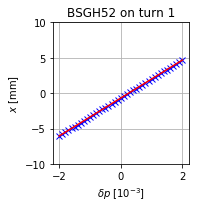

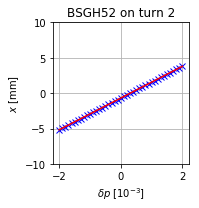

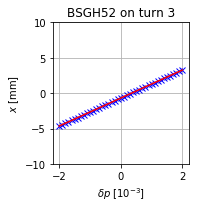

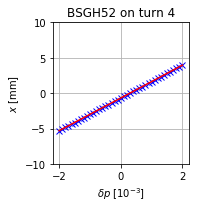

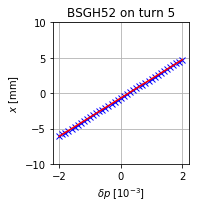

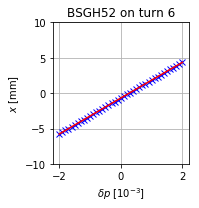

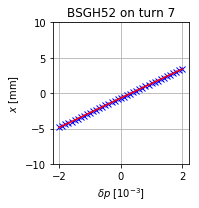

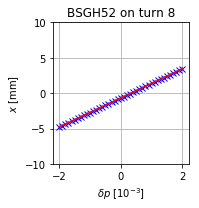

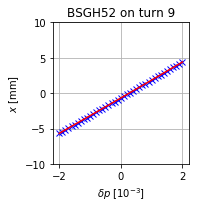

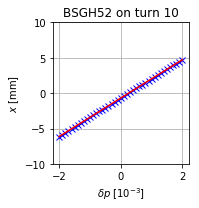

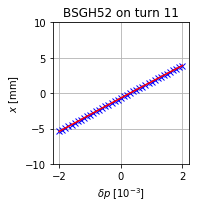

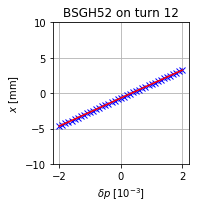

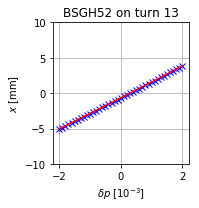

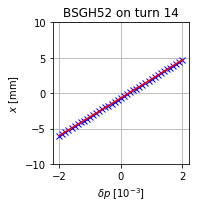

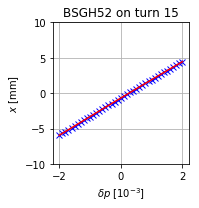

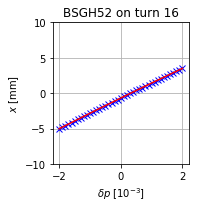

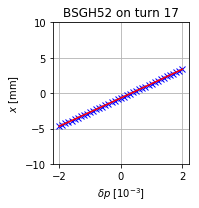

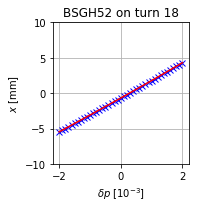

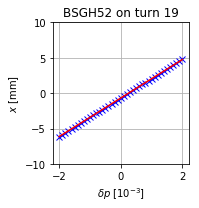

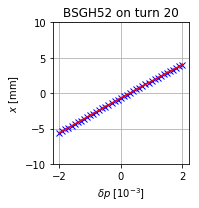

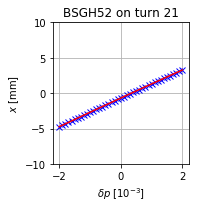

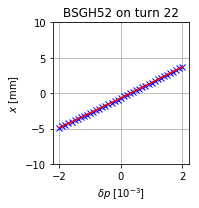

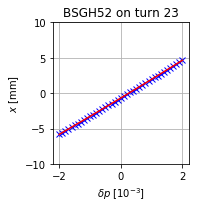

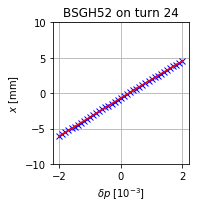

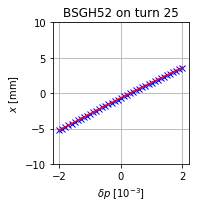

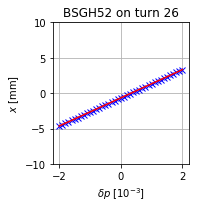

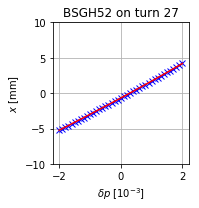

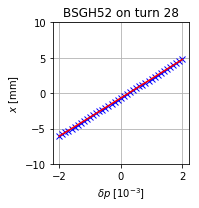

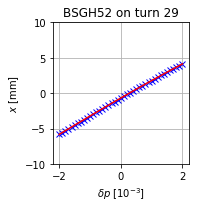

In [10]:
# Plot the simulated TbT H dispersion with measured fit constants:

# ReM optics

def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)
    
# Define initial particle coordinates for tracking
DX0 = Md_fit(1, popt_ReM_H[0], popt_ReM_H[1], popt_ReM_H[2], popt_ReM_H[3])*0.94
DPX0 = data_ptc_ref['DISP2']['PI.BSG52']*2.8
DELTAP = np.arange(-2,2.1,0.1)*1e-3

X0 = DELTAP*DX0 + co[0]
PX0 = DELTAP*DPX0 + co[1]

print DX0, DPX0

def quadratic(x,a,m,c):
    return a*x**2 + x*m + c

def cubic(x,a,m,c,b):
    return a*x**2 + x*m + c + b*x**3

particle0 = []
for idx, i in enumerate(DELTAP*header_ptc['BETA']):
    particle0.append([X0[idx],PX0[idx],0,0,0,i])
    #print i, X0[idx]

particles_tot, out_log = trackPTC(np.array(particle0).T, 30, 68, co, [C_OTM], [exps_OTM], turnByTurn=True)

N_turns = 30
#fig = plt.figure('BSGH52 at Turn' + str(i+1))
SEM_D_ReM = []  
SEM_D2_ReM = []     
    
for i in range(0,N_turns-1):
    fig = plt.figure('ReM optics BSGH52 on turn ' + str(i+1), figsize = (3,3) )
    plt.title('BSGH52 on turn ' + str(i+1) )
    plt.plot(particles_tot[5,:,i]*1e3/header_ptc['BETA'],particles_tot[0,:,i]*1e3,'bx')
    popt, pcov = curve_fit(cubic,particles_tot[5,:,i]/header_ptc['BETA'],particles_tot[0,:,i])
    DELTAP_range = np.arange(np.min(particles_tot[5,:,i])/header_ptc['BETA'],np.max(particles_tot[5,:,i]/header_ptc['BETA']),0.1e-4)        
    plt.plot(DELTAP_range*1e3,cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3])*1e3,'-r')
    SEM_D_ReM.append(popt[1])
    SEM_D2_ReM.append(popt[0]) 
    plt.xlabel(r'$\delta p$ [$10^{-3}$]')
    plt.ylabel(r'$x$ [mm]')
    plt.ylim(-10,10)
    plt.xlim(DELTAP_range[0]*1.1e3,DELTAP_range[-1]*1.1e3)
    plt.tight_layout()
    plt.grid()
    plt.savefig('./gif/ReM/NL_DX/BSGH/PT_X_turn' + str(i+1) + '.png')
    #fig.clear()
    #plt.close(fig)


0.22201015031196222
-0.000678906156917017
0.10811731437690071


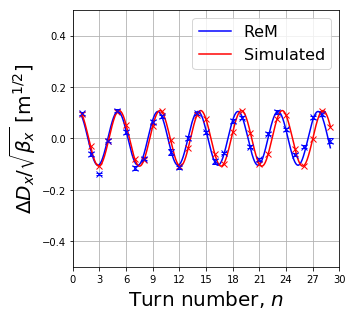

In [11]:
# Plot together the measured and simulated turn-by-turn Normalised dispersion:

plt.figure(figsize=(5,4.5))

popt_ReM_H, pcov_ReM_H = curve_fit(Md_fit,turnN,SEM_D_ReM_H,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.45,np.inf)))
plt.errorbar(turnN,(SEM_D_ReM_H-popt_ReM_H[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D_err_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3)
plt.plot(turnN_fine,(Md_fit(turnN_fine,popt_ReM_H[0],popt_ReM_H[1],popt_ReM_H[2],popt_ReM_H[3])-popt_ReM_H[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'b',label = 'ReM')

popt_ReM_H_sim, pcov_ReM_H_sim = curve_fit(Md_fit,turnN,SEM_D_ReM,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.45,np.inf)))
plt.plot(range(1,N_turns),(SEM_D_ReM-popt_ReM_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'xr')
plt.plot(turnN_fine,(Md_fit(turnN_fine,popt_ReM_H_sim[0],popt_ReM_H_sim[1],popt_ReM_H_sim[2],popt_ReM_H_sim[3])-popt_ReM_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'r',label = 'Simulated')


plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\Delta D_{x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
#plt.title('PI.BSG52')
plt.xlim((0,30))
plt.ylim((-0.5,0.5))
plt.grid()
plt.legend(loc = 'lower right')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/ReM/BSGH_DX.png')
print popt_ReM_H[2]/2/np.pi

print popt[2]
print popt_ReM_H_sim[1]/np.sqrt(data_ptc_ref['BETX']['PI.BSG52'])

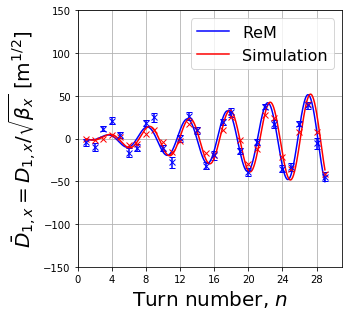

In [12]:
# Plot the Matched turn-by-turn non-linear dispersion

def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

plt.figure(figsize=(5,4.5))

plt.errorbar(turnN,SEM_D2_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),yerr=SEM_D2_err_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']), linestyle = 'None', marker = 'x',color = 'b', capsize = 3) 
popt, pcov = curve_fit(Md_ramp_fit,turnN,SEM_D2_ReM_H/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,50./25,1.31,-np.inf),(10,50./10,1.33,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt[0],popt[1],popt[2],popt[3]),'-b',label = 'ReM')

plt.plot(turnN,SEM_D2_ReM,'xr')
popt_ReM_H_sim_D2, pcov_ReM_H_sim_D2 = curve_fit(Md_ramp_fit,turnN,SEM_D2_ReM/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,50./25,1.31,-np.inf),(10,50./10,1.33,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt_ReM_H_sim_D2[0],popt_ReM_H_sim_D2[1],popt_ReM_H_sim_D2[2],popt_ReM_H_sim_D2[3]),'-r',label = 'Simulation')

plt.grid()
plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\bar{D}_{1,x} = D_{1,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.xlim((0,N_turns+1))
plt.ylim((-150,150))

plt.legend(loc = 'lower left')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/ReM/BSGH_D2X.png')

2.5684997823405133 -0.008613757385440892
Closed-orbit removed for tracking, X0 = 4.675291319400907e-18


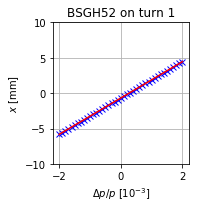

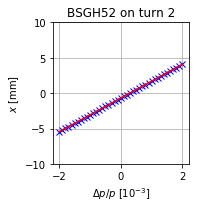

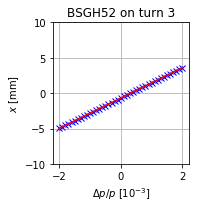

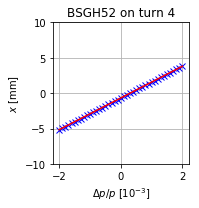

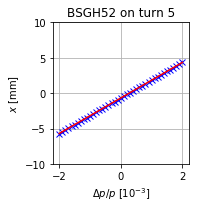

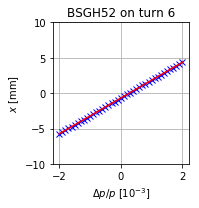

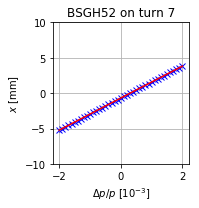

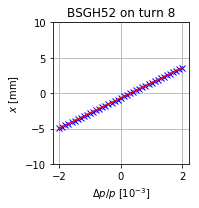

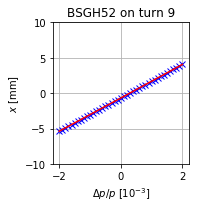

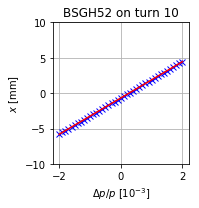

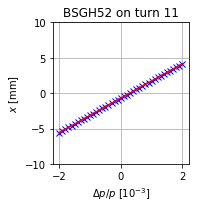

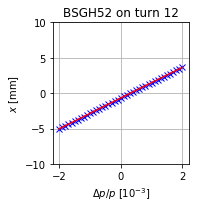

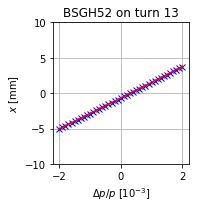

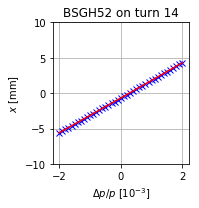

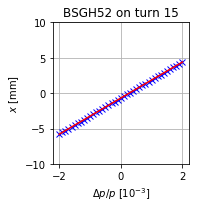

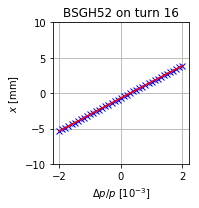

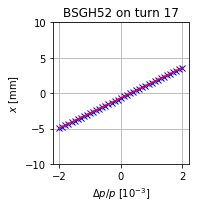

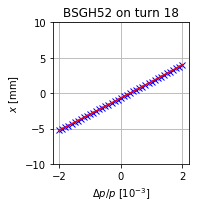

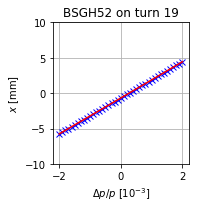

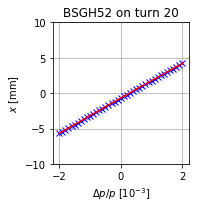

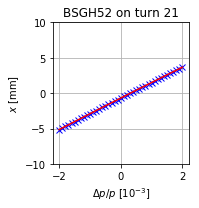

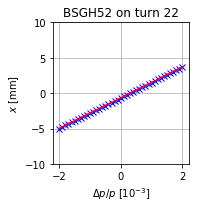

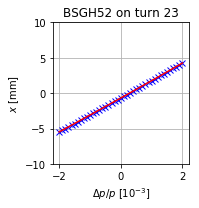

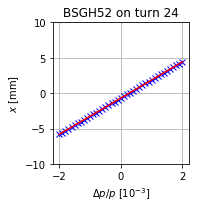

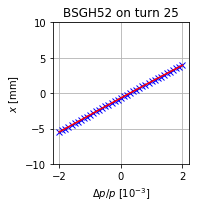

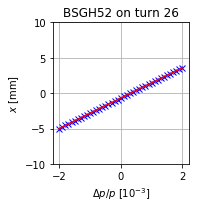

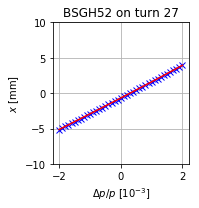

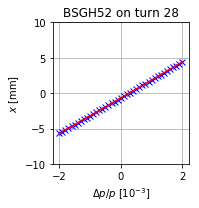

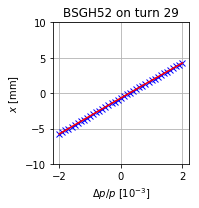

In [13]:
# Plot the simulated TbT H dispersion with measured fit constants:

# ReM optics

def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)
    
# Define initial particle coordinates for tracking
DX0 = data_ptc_ref['DISP1']['PI.BSG52']/header_ptc['BETA']
DPX0 = data_ptc_ref['DISP2']['PI.BSG52']/header_ptc['BETA']
DELTAP = np.arange(-2,2.1,0.1)*1e-3

X0 = DELTAP*DX0 + co[0]
PX0 = DELTAP*DPX0 + co[1]

print DX0, DPX0

def cubic(x,a,m,c,b):
    return a*x**2 + x*m + c + b*x**3

particle0 = []
for idx, i in enumerate(DELTAP*header_ptc['BETA']):
    particle0.append([X0[idx],PX0[idx],0,0,0,i])
    #print i, X0[idx]

particles_tot, out_log = trackPTC(np.array(particle0).T, 30, 68, co, [C_OTM], [exps_OTM], turnByTurn=True)

N_turns = 30
#fig = plt.figure('BSGH52 at Turn' + str(i+1))
SEM_D_M = []  
SEM_D2_M = []     
    
for i in range(0,N_turns-1):
    fig = plt.figure('Matched optics BSGH52 on turn ' + str(i+1), figsize = (3,3) )
    plt.title('BSGH52 on turn ' + str(i+1) )
    plt.plot(particles_tot[5,:,i]*1e3/header_ptc['BETA'],particles_tot[0,:,i]*1e3,'bx')
    popt, pcov = curve_fit(cubic,particles_tot[5,:,i]/header_ptc['BETA'],particles_tot[0,:,i])
    DELTAP_range = np.arange(np.min(particles_tot[5,:,i])/header_ptc['BETA'],np.max(particles_tot[5,:,i]/header_ptc['BETA']),0.1e-4)        
    plt.plot(DELTAP_range*1e3,cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3])*1e3,'-r')
    SEM_D_M.append(popt[1])
    SEM_D2_M.append(popt[0]) 
    plt.xlabel(r'$\Delta p/p$ [$10^{-3}$]')
    plt.ylabel(r'$x$ [mm]')
    plt.ylim(-10,10)
    plt.xlim(DELTAP_range[0]*1.1e3,DELTAP_range[-1]*1.1e3)
    plt.tight_layout()
    plt.grid()
    plt.savefig('./gif/M/NL_DX/BSGH/PT_X_turn' + str(i+1) + '.png')



2.3523331845847757


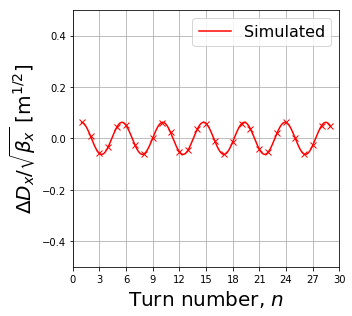

In [14]:
# Plot together the matched, simulated turn-by-turn Normalised dispersion:

plt.figure(figsize=(5,4.5))

popt_M_H_sim, pcov_M_H_sim = curve_fit(Md_fit,turnN,SEM_D_M,method = 'trf',bounds =((0,0,1.3,-np.inf),(5,5,1.45,np.inf)))
plt.plot(range(1,N_turns),(SEM_D_M-popt_M_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'xr')
plt.plot(turnN_fine,(Md_fit(turnN_fine,popt_M_H_sim[0],popt_M_H_sim[1],popt_M_H_sim[2],popt_M_H_sim[3])-popt_M_H_sim[0])/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),'r',label = 'Simulated')

plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\Delta D_{x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
#plt.title('PI.BSG52')
plt.xlim((0,30))
plt.ylim((-0.5,0.5))
plt.grid()
plt.legend(loc = 'lower right')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/M/BSGH_DX.png')
print popt_M_H_sim[0]

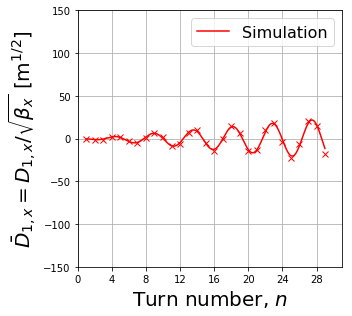

In [15]:
# Plot the Matched turn-by-turn non-linear dispersion

def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

plt.figure(figsize=(5,4.5))

plt.plot(turnN,SEM_D2_M,'xr')
popt_M_H_sim_D2, pcov_M_H_sim_D2 = curve_fit(Md_ramp_fit,turnN,SEM_D2_M/np.sqrt(data_ptc_ref['BETX']['PI.BSG52']),method = 'trf',bounds =((-10,20./24,1.25,-np.inf),(10,50./10,1.4,np.inf)))
plt.plot(turnN_fine,Md_ramp_fit(turnN_fine,popt_M_H_sim_D2[0],popt_M_H_sim_D2[1],popt_M_H_sim_D2[2],popt_M_H_sim_D2[3]),'-r',label = 'Simulation')

plt.grid()
plt.xlabel('Turn number, $n$')
plt.ylabel(r'$\bar{D}_{1,x} = D_{1,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.xlim((0,N_turns+1))
plt.ylim((-150,150))
plt.legend(loc = 'lower left')
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.legend(prop=dict(size=16))

plt.tight_layout()

plt.savefig('./plots/M/BSGH_D2X.png')